In [1]:
# CALCULATE THE HORIZONTAL STRAIN
# A script to calculate strain rate from input velocity field
# This script uses the oocgcm python package from Julien le Sommer (http://oocgcm.readthedocs.io/en/latest/index.html)

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from oocgcm.oceanmodels.nemo import grids
from oocgcm.core.grids import VectorField2d
from netCDF4 import Dataset
import xarray
import time

In [2]:
# SPECIFY DATA LOCATION
rootdir = '/home/ocean2/'
griddir = 'DRAKKAR_5d/ORCA025.L75-GJM189-S/NATL/GRID/'
datadir = 'graemem/ariane/data_link/5d/'
savedir = 'DRAKKAR_5d/ORCA025.L75-GJM189-S/NATL/strain_files/'
# Define chunks
chunks = (640,526)
xr_chunks = {'x': chunks[-1], 'y': chunks[-2]}
# Load grid descriptor
grd = grids.nemo_2d_grid(nemo_coordinate_file = rootdir+griddir+'ORCA025.L75-GJM189_mesh_hgr.nc',
                        nemo_byte_mask_file = rootdir+griddir+'ORCA025.L75-GJM189_byte_mask.nc',
                        chunks=xr_chunks)

In [6]:
# Loop through timesteps
for timestep in range(4016,4017):
    timethen = time.time()
    # Define timestep as string
    t = str(timestep).zfill(4)
    print 'time is '+t

    # LOAD DATA
    # Load U and V velocities
    datu = xarray.open_dataset(rootdir+datadir+'ORCA025.L75-GJM189_'+t+'_gridU.nc',
                                 chunks=xr_chunks)['vozocrtx'][0,:,:,:]
    datu = datu.rename({'depthu':'deptht'}) # Name z dimension same in both velocity fields
    datv = xarray.open_dataset(rootdir+datadir+'ORCA025.L75-GJM189_'+t+'_gridV.nc',
                                 chunks=xr_chunks)['vomecrty'][0,:,:,:]
    datv = datv.rename({'depthv':'deptht'}) # Name z dimension same in both velocity fields
    velocity = VectorField2d(datu,datv,x_component_grid_location='u',y_component_grid_location='v')

    # CALCULATE STRAIN
    # Calculate horizontal gradients
    grad = grd.horizontal_gradient(velocity)
    # Average cross gradients onto T-points
    # Set up new dataarray initially, to put averaged values into
    grad_T = grd.horizontal_gradient(velocity)
    for k in range(0,75):
        #print k
        dudy_u = grd.change_grid_location_f_to_u(grad.xy_component[k,:,:,0],conserving='area')
        dvdx_v = grd.change_grid_location_f_to_v(grad.yx_component[k,:,:,0],conserving='area')
        grad_T.xy_component.values[k,:,:,:] = grd.change_grid_location_u_to_t(dudy_u[:,:,0],conserving='area')
        grad_T.yx_component.values[k,:,:,:] = grd.change_grid_location_v_to_t(dvdx_v[:,:,0],conserving='area')
    # Calculate strain
    strain2 = (grad_T.xx_component - grad_T.yy_component)**2 + (grad_T.yx_component + grad_T.xy_component)**2
    # Turn into timescale
    tstrain=np.reciprocal(np.sqrt(strain2))
    
    # SAVE STRAIN TO NETCDF
    s = tstrain.to_dataset(name='vostrain')
    s.to_netcdf(rootdir+savedir+'ORCA025.L75-GJM189_'+t+'_gridS.nc','w')
    
    # PRINT ELAPSED TIME
    print 'elapsed runtime is '+str(time.time()-timethen)

time is 4016
elapsed runtime is 101.545346975


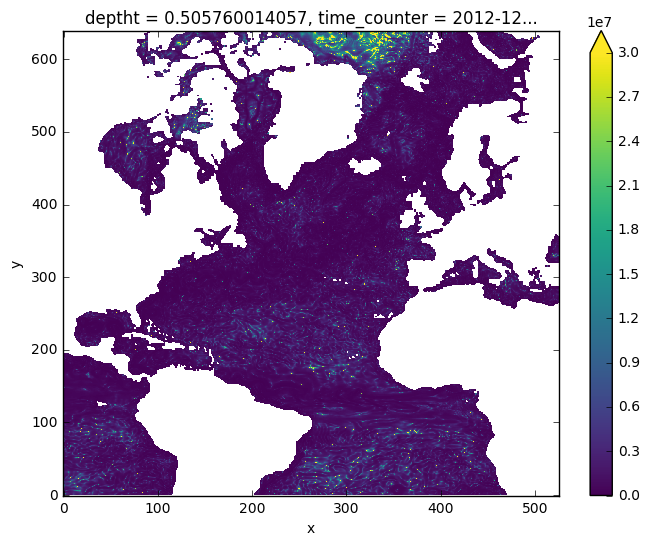

In [4]:
# PLOT STRAIN
tstrain = np.reciprocal(np.sqrt(strain2))
fig = plt.figure(figsize=(8,6))
ax = tstrain[0,:,:,:].plot(vmin = 0, vmax = 30000000)